# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.34 s, sys: 156 ms, total: 2.5 s
Wall time: 2.54 s


In [5]:
%%time
rsc.utils.anndata_to_GPU(adata)

CPU times: user 59.1 ms, sys: 207 ms, total: 266 ms
Wall time: 266 ms


In [6]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.831617832183838


## Preprocessing

In [7]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [8]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 5.99 ms, sys: 5 µs, total: 5.99 ms
Wall time: 5.89 ms


In [9]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.86 ms, sys: 0 ns, total: 5.86 ms
Wall time: 5.79 ms


In [10]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT","RIBO"])

CPU times: user 86.8 ms, sys: 7.8 ms, total: 94.6 ms
Wall time: 171 ms


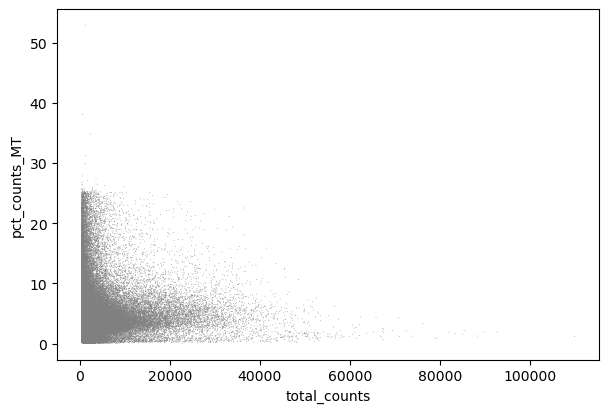

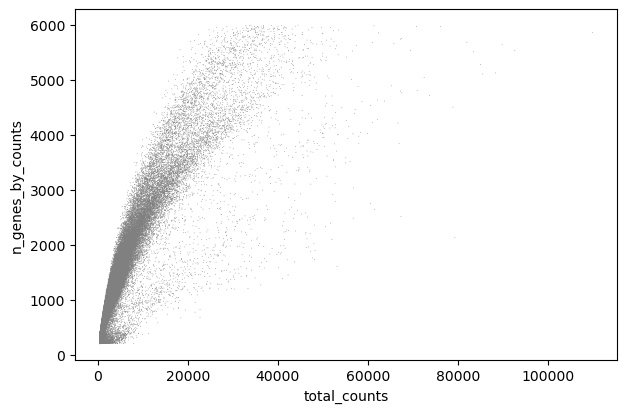

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

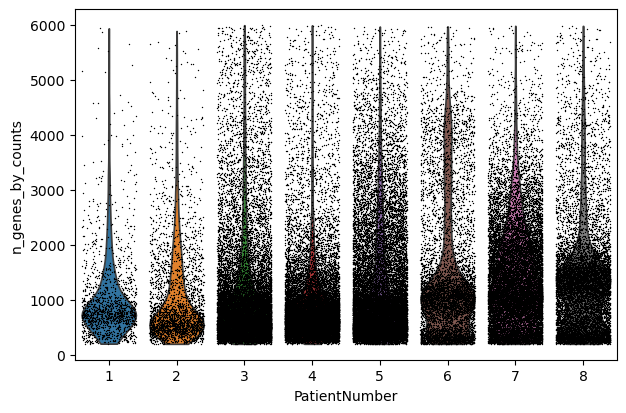

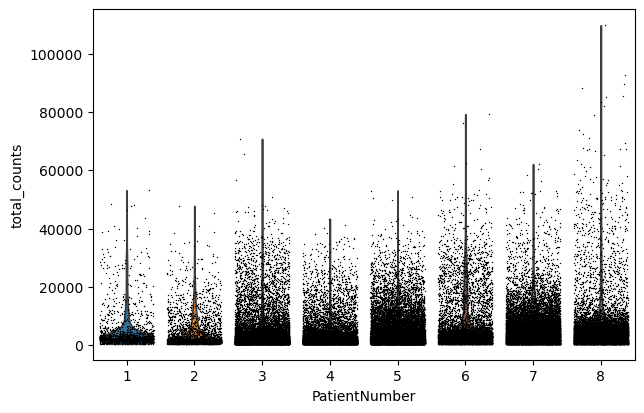

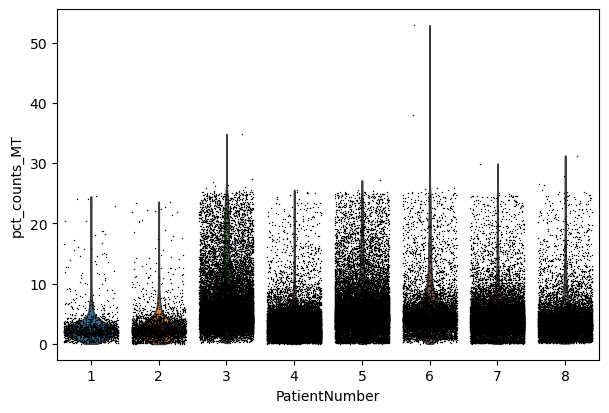

In [12]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [13]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 17 ms, sys: 5.28 ms, total: 22.3 ms
Wall time: 21.2 ms


We also filter out genes that are expressed in less than 3 cells.

In [14]:
%%time
rsc.pp.filter_genes(adata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 63.3 ms, sys: 19 ms, total: 82.4 ms
Wall time: 94.1 ms


The size of our count matrix is now reduced.

In [15]:
adata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [16]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 253 µs, sys: 1.16 ms, total: 1.41 ms
Wall time: 7.84 ms


Next, we data transform the count matrix.

In [17]:
%%time
rsc.pp.log1p(adata)

CPU times: user 1.69 ms, sys: 612 µs, total: 2.3 ms
Wall time: 2.2 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `cell_ranger` for selecting highly variable genes based on the log normalized counts in `.X`

In [18]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="cell_ranger")

CPU times: user 239 ms, sys: 34.9 ms, total: 274 ms
Wall time: 311 ms


Now we safe this verion of the AnnData as adata.raw. 

In [19]:
%%time
adata.raw = adata

CPU times: user 85.9 ms, sys: 53.3 ms, total: 139 ms
Wall time: 138 ms


Now we restrict our AnnData object to the highly variable genes.

In [20]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 117 ms, sys: 116 ms, total: 233 ms
Wall time: 233 ms


Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [21]:
%%time
rsc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 547 ms, sys: 639 ms, total: 1.19 s
Wall time: 1.23 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [22]:
%%time
rsc.pp.scale(adata,max_value=10)

CPU times: user 28.1 ms, sys: 4.98 ms, total: 33.1 ms
Wall time: 45.9 ms


Now we move `.X` out of the GPU.

In [23]:
%%time
rsc.utils.anndata_to_CPU(adata)

CPU times: user 270 ms, sys: 112 ms, total: 382 ms
Wall time: 382 ms


In [24]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 6.3091535568237305


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [25]:
%%time
rsc.tl.pca(adata, n_comps = 100)

CPU times: user 1.4 s, sys: 601 ms, total: 2 s
Wall time: 2.01 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

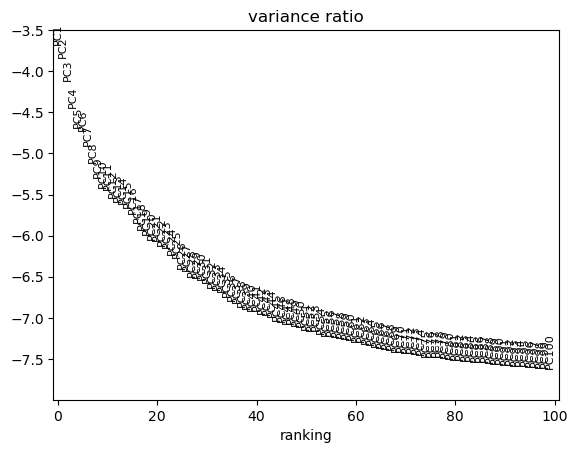

In [26]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [27]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 245 ms, sys: 26.7 ms, total: 271 ms
Wall time: 277 ms


Next we calculate the UMAP embedding using rapdis.

In [28]:
%%time
rsc.tl.umap(adata)

CPU times: user 250 ms, sys: 12.5 ms, total: 262 ms
Wall time: 261 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [29]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 3.38 s, sys: 772 ms, total: 4.15 s
Wall time: 5.99 s


In [30]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 435 ms, sys: 551 ms, total: 986 ms
Wall time: 987 ms


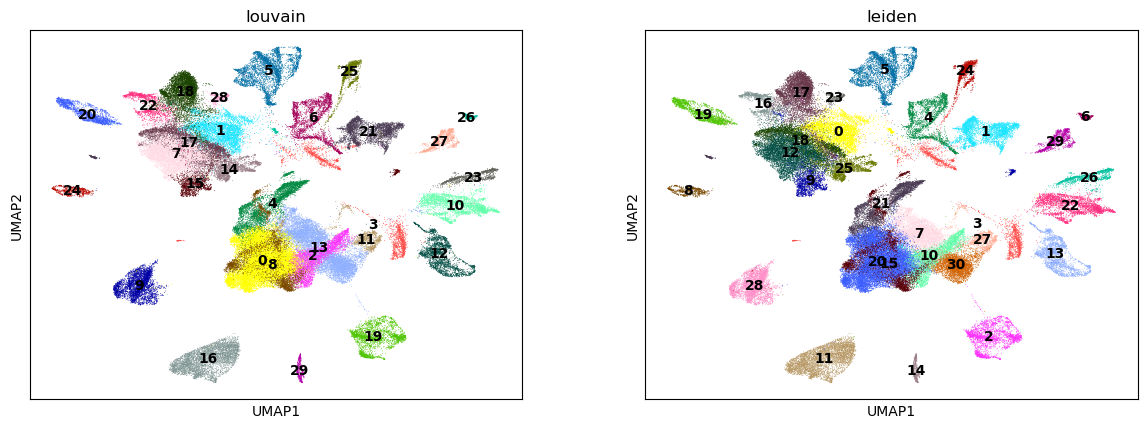

CPU times: user 695 ms, sys: 180 ms, total: 876 ms
Wall time: 697 ms


In [31]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

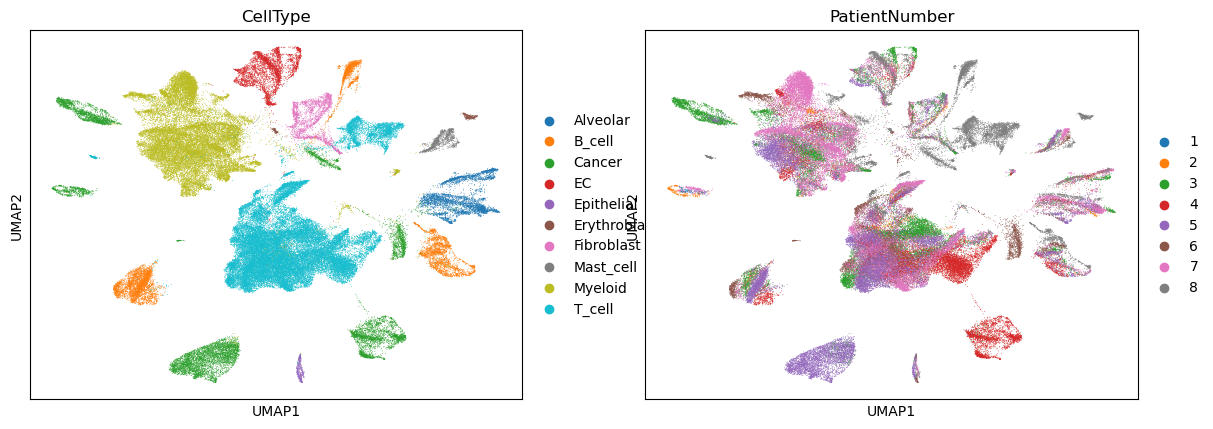

In [32]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [33]:
%%time
rsc.tl.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

[W] [16:46:52.971201] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.35 s, sys: 1.34 s, total: 2.69 s
Wall time: 2.69 s


In [34]:
rsc.tl.kmeans(adata, n_clusters=8)

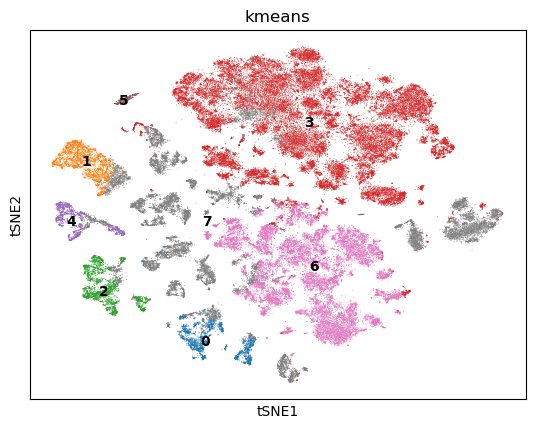

CPU times: user 308 ms, sys: 151 ms, total: 459 ms
Wall time: 277 ms


In [35]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

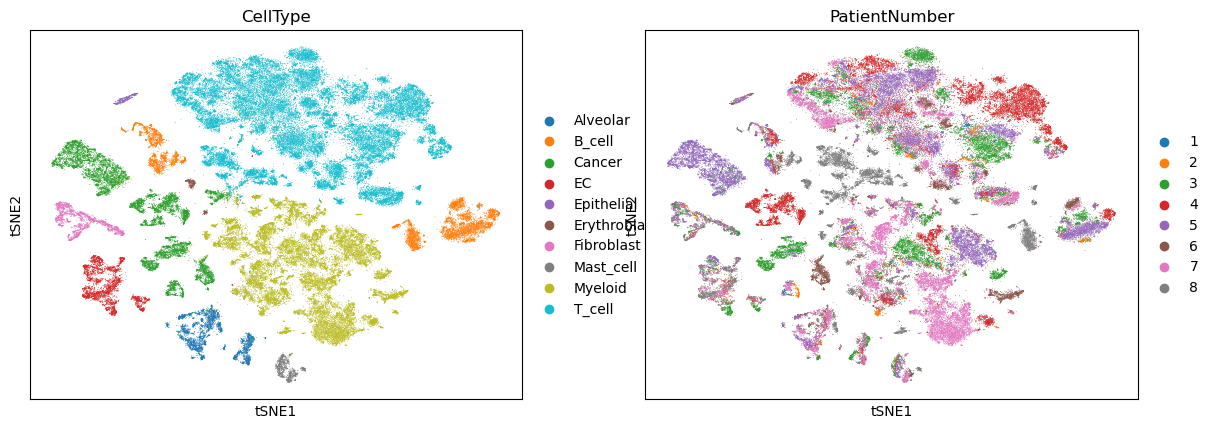

In [36]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [37]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 1.93 s, sys: 596 ms, total: 2.52 s
Wall time: 2.55 s


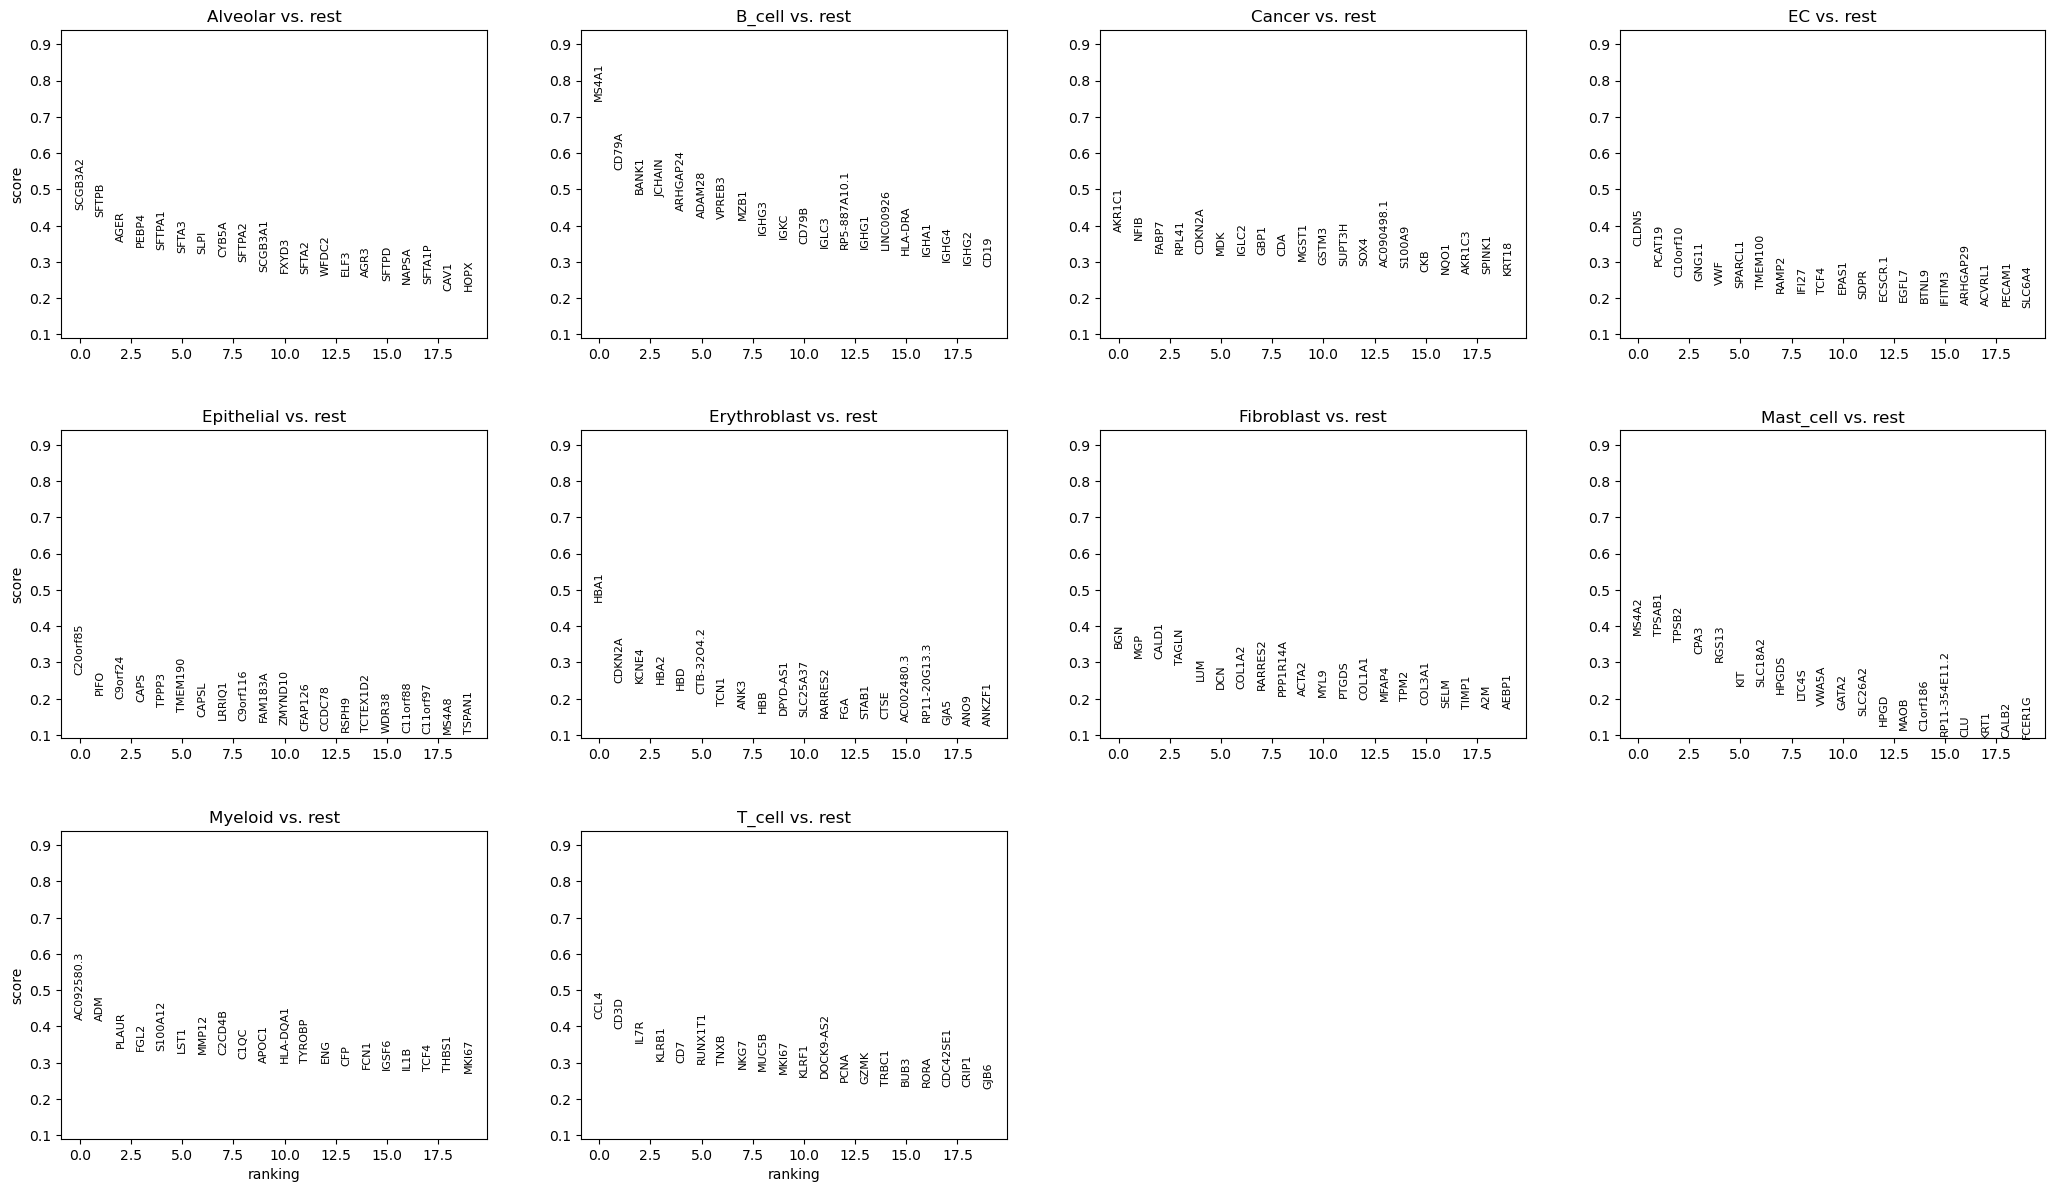

In [38]:
sc.pl.rank_genes_groups(adata)

In [39]:
post_time = time.time()

In [40]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 18.532944440841675


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [41]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

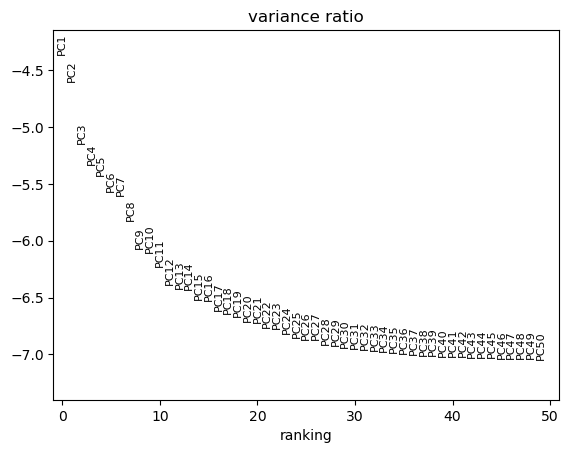

CPU times: user 848 ms, sys: 488 ms, total: 1.34 s
Wall time: 1.16 s


In [42]:
%%time
rsc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [43]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 428 ms, sys: 283 ms, total: 711 ms
Wall time: 712 ms


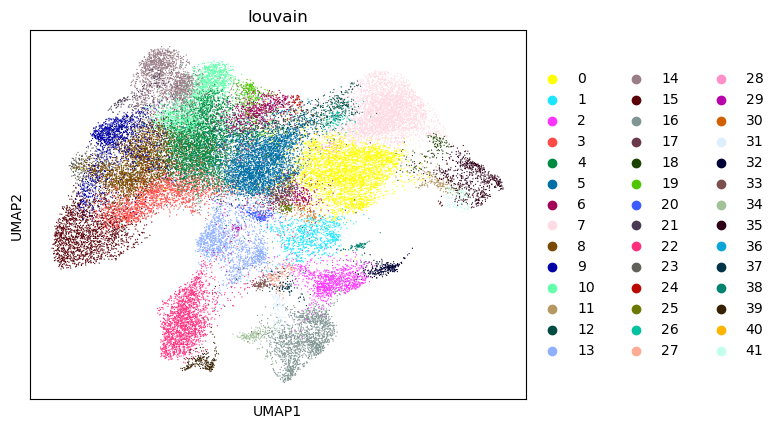

In [44]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [45]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 382 ms, sys: 1.21 s, total: 1.59 s
Wall time: 187 ms


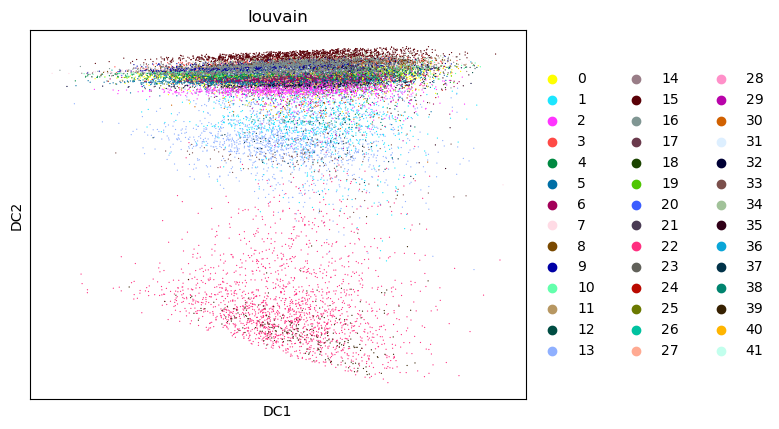

In [46]:
sc.pl.diffmap(tdata, color='louvain')

In [47]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 332 ms, sys: 11.3 ms, total: 343 ms
Wall time: 353 ms


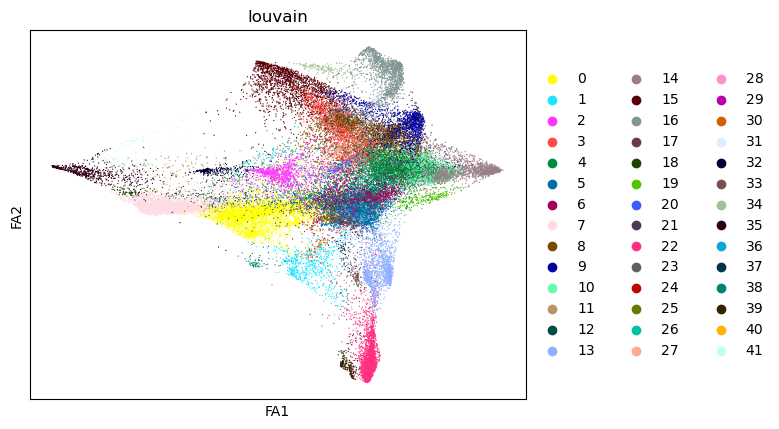

In [48]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [49]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 29.35686707496643


## Decoupler-GPU

Here I introduce 2 functions of the `decoupler` package that have been accelerated with cupy: `mlm`and `wsum`.
You can use the same `nets` that you would use with the CPU implementation.

In [50]:
import decoupler as dc

In [51]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])

In [52]:
%%time
rsc.dcg.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running mlm on mat with 91068 samples and 25656 targets for 297 sources.


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


CPU times: user 8.44 s, sys: 2.9 s, total: 11.3 s
Wall time: 11.4 s


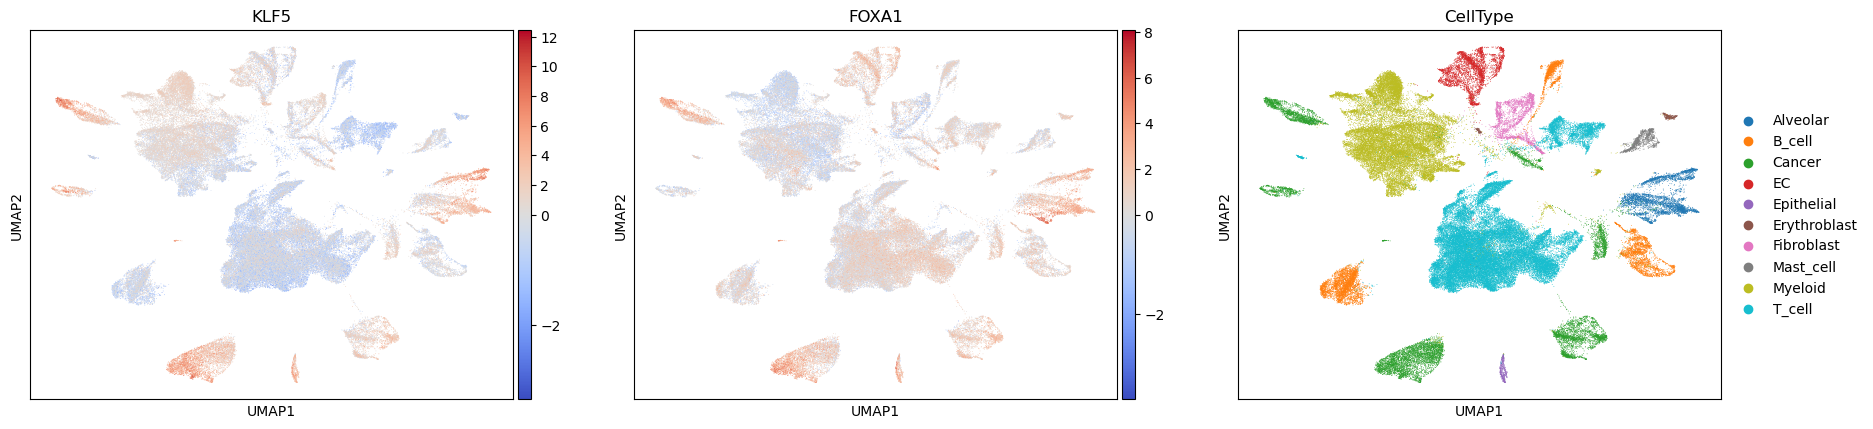

In [53]:
acts_mlm = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.umap(acts_mlm, color=['KLF5',"FOXA1", 'CellType'], cmap='coolwarm', vcenter=0)

In [54]:
model = dc.get_progeny(organism='human', top=100)

In [55]:
%%time
rsc.dcg.run_wsum(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running wsum on mat with 91068 samples and 25656 targets for 14 sources.


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]

CPU times: user 18.6 s, sys: 4.91 s, total: 23.5 s
Wall time: 23.6 s


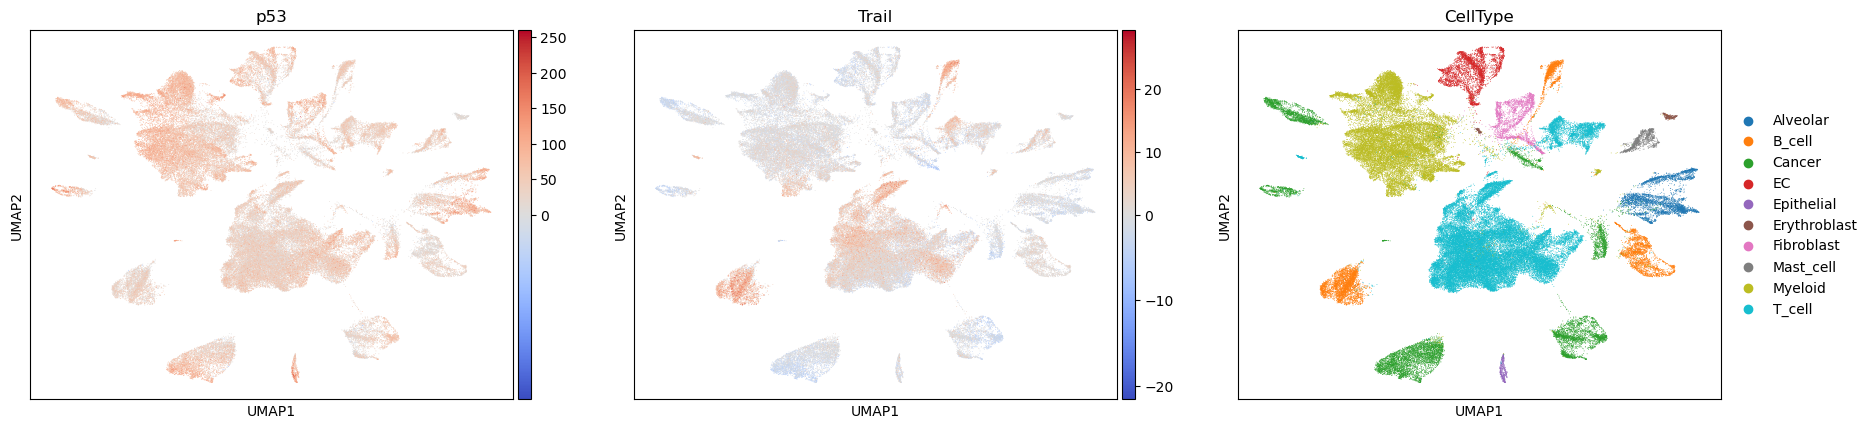

In [56]:
acts_wsum = dc.get_acts(adata, obsm_key='wsum_estimate')
sc.pl.umap(acts_wsum, color=['p53',"Trail", 'CellType'], cmap='coolwarm', vcenter=0)